In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('.')
sys.path.append('../')
import os
import torch
import numpy as np
import pandas as pd
import config as cfg
import config as config
import src.utils.io as io

In [15]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [4]:
window_duration = 14.937
window_length = int(window_duration * cfg.SAMPLING_RATE)

In [53]:
def calculate_monthly_behavior_proportions_optimized(data_folder: str, behaviors: list):
    """
    Computes behavior proportions by first getting daily counts from each file
    before combining, making it highly memory-efficient.

    Args:
        data_folder (str): The path to the folder containing the CSV files.
        behaviors (list): List of all possible behaviors to include in the output.
    """
    
    if not os.path.isdir(data_folder):
        print(f"Error: Folder not found at '{data_folder}'")
        return

    all_daily_counts = []

    print("Reading files and calculating daily counts...")
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(data_folder, filename)
            try:
                filename_stem = os.path.splitext(filename)[0]
                parts = filename_stem.split('_')
                individual_name = parts[0]
                date_str = parts[1]

                df = pd.read_csv(file_path)

                # --- Handle interchangeable column names ---
                if "behavior" in df.columns:
                    behavior_col_name = "behavior"
                elif "Most probable behavior" in df.columns:
                    behavior_col_name = "Most probable behavior"
                else:
                    raise ValueError(
                        "CSV must contain either 'behavior' or 'Most probable behavior' column."
                    )

                if df[behavior_col_name].empty:
                    continue

                # --- Calculate daily counts for that file ---
                daily_counts = df[behavior_col_name].value_counts()

                # Convert to DataFrame
                counts_df = daily_counts.reset_index()
                counts_df.columns = ['behavior', 'count']
                
                # Add metadata
                counts_df['individual'] = individual_name
                counts_df['date'] = pd.to_datetime(date_str)
                
                all_daily_counts.append(counts_df)
                
            except Exception as e:
                print(f"Warning: Could not process file '{filename}'. Reason: {e}")

    if not all_daily_counts:
        print("No valid data files were found to process.")
        return

    # Concatenate all daily summaries
    counts_summary_df = pd.concat(all_daily_counts, ignore_index=True)

    # Add month column for aggregation
    counts_summary_df['month'] = counts_summary_df['date'].dt.to_period('M')

    print("\nAggregating counts and calculating final proportions...")

    # Sum daily counts to get monthly totals
    monthly_totals = (
        counts_summary_df
        .groupby(['individual', 'month', 'behavior'])['count']
        .sum()
    )

    # Convert to wide format
    wide_df = monthly_totals.unstack(level='behavior')
    wide_df = wide_df.reindex(columns=behaviors, fill_value=0)
    wide_df = wide_df.fillna(0)
    final_df = wide_df.reset_index().round(2)

    return final_df


In [61]:
data_folder = os.path.join(cfg.VECTRONICS_BEHAVIOR_EVAL_PATH, 'evals')
monthly_counts = calculate_monthly_behavior_proportions_optimized(data_folder, cfg.RAW_BEHAVIORS)


Reading files and calculating daily counts...

Aggregating counts and calculating final proportions...


In [72]:
# Compute total counts across behaviors for each row (month)
row_sums = monthly_counts[cfg.RAW_BEHAVIORS].sum(axis=1)

# Determine validity (each behavior >= 1% of total)
valid_mask = (
    monthly_counts[cfg.RAW_BEHAVIORS]
    .gt(0.005 * row_sums, axis=0)
    .all(axis=1)
)

# Add a 'valid_month' column and total duration
monthly_counts = monthly_counts.copy()
monthly_counts["valid_month"] = valid_mask
monthly_counts["total_duration [d]"] = (row_sums*14.937)/(24*3600)

# Print validity summary including total duration
print("\n--- Month Validity Summary ---")
validity_summary = monthly_counts[['individual', 'month', 'total_duration [d]', 'valid_month']]
print(validity_summary)

# Keep only valid months for downstream analysis
valid_monthly_counts = monthly_counts[monthly_counts["valid_month"]].reset_index(drop=True)
print(f"\nNumber of valid months: {len(valid_monthly_counts)} out of {len(monthly_counts)} total months.")

# Compute proportions for valid months
monthly_proportions = valid_monthly_counts.copy()
if not monthly_proportions.empty:
    print("\n--- Monthly Behavior Proportions (Valid Months Only) ---")
    row_totals = monthly_proportions[cfg.RAW_BEHAVIORS].sum(axis=1)
    monthly_proportions[cfg.RAW_BEHAVIORS] = (
        monthly_proportions[cfg.RAW_BEHAVIORS]
        .div(row_totals, axis=0)
        .fillna(0) * 100
    )
    print(monthly_proportions.head())
else:
    print("\nNo valid months found.")



--- Month Validity Summary ---
behavior individual    month  total_duration [d]  valid_month
0               ash  2021-03            3.222692        False
1               ash  2021-08            1.978634        False
2               ash  2021-10            7.536961         True
3               ash  2021-11           30.118109         True
4               ash  2021-12           31.121862         True
..              ...      ...                 ...          ...
63            palus  2022-06           30.066590         True
64            palus  2022-07           27.604060        False
65            palus  2022-08           31.121689        False
66            palus  2022-09           30.118282        False
67            palus  2022-10           20.829162        False

[68 rows x 4 columns]

Number of valid months: 52 out of 68 total months.

--- Monthly Behavior Proportions (Valid Months Only) ---
behavior individual    month   Feeding    Moving   Resting   Running  \
0               ash

In [73]:
def bootstrap_class_distribution(df: pd.DataFrame, behavior_cols: list, alpha: float = 0.05) -> pd.DataFrame:
    """
    Estimates class distribution and constructs a confidence interval using bootstrapping.

    Args:
        df (pd.DataFrame): DataFrame with columns for individual, month, and behavior counts.
        behavior_cols (list): A list of the column names that contain behavior counts.
        n_iterations (int): The number of bootstrap samples to generate.
        alpha (float): The significance level for the confidence interval (e.g., 0.05 for 95% CI).

    Returns:
        pd.DataFrame: A DataFrame containing the overall proportion, and the lower and
                      upper bounds of the confidence interval for each behavior.
    """
    # --- 1. Calculate the Overall Proportion (Point Estimate) ---
    # Sum the counts for each behavior across the entire dataset
    total_counts = df[behavior_cols].sum().values
    # Get the grand total of all observations
    grand_total = total_counts.sum()
    # Calculate the proportion for each behavior
    overall_proportions = total_counts / grand_total

    # --- 2. Perform Bootstrapping to get a distribution of proportions ---
    bootstrap_proportions_list = []

    print(f"Running {len(df)} bootstrap iterations...")
    for i, row in df.iterrows():
        
        # Calculate proportions for this specific bootstrap sample
        sample_total_counts = row[behavior_cols].values
        sample_grand_total = sample_total_counts.sum()
        
        # Avoid division by zero if a sample happens to be empty or all zeros
        if sample_grand_total == 0:
            continue
            
        sample_proportions = sample_total_counts / sample_grand_total

        bootstrap_proportions_list.append(sample_proportions)

    # Convert the list of results into a DataFrame
    bootstrap_df = pd.DataFrame(bootstrap_proportions_list)

    # --- 3. Calculate the Confidence Interval from the bootstrap distribution ---
    lower_quantile = alpha / 2.0  # e.g., 0.05 / 2 = 0.025
    upper_quantile = 1.0 - (alpha / 2.0) # e.g., 1 - 0.025 = 0.975

    # Find the proportions at these percentiles
    ci_lower = bootstrap_df.quantile(lower_quantile)
    ci_upper = bootstrap_df.quantile(upper_quantile)

    # --- 4. Combine results into a final DataFrame ---
    result_df = pd.DataFrame({
        'behavior': behavior_cols,
        'overall_proportion': overall_proportions*100,
        'ci_lower_bound': ci_lower*100,
        'ci_upper_bound': ci_upper*100
    })

    return result_df.round(4) # Round for cleaner output

In [74]:
result_df = bootstrap_class_distribution(valid_monthly_counts, cfg.RAW_BEHAVIORS, alpha = 0.05)
result_df = result_df.set_index('behavior')
print(result_df)

Running 52 bootstrap iterations...
          overall_proportion  ci_lower_bound  ci_upper_bound
behavior                                                    
Feeding               1.3303          0.6623          2.7761
Moving                4.3874          1.7660          7.8909
Resting               3.2837          1.1542          9.3914
Running               1.8075          0.9516          2.9849
Vigilant             89.1911         83.2784         93.1689


In [65]:
acc_data = pd.read_csv(io.get_matched_data_path())
acc_data = adjust_behavior_and_durations(acc_data, cfg.RAW_COLLAPSE_BEHAVIORS_MAPPING, cfg.RAW_BEHAVIORS)

# Group and sum durations in hours
duration_table = np.round(acc_data.groupby('behavior')['duration'].sum().div(3600), 4)

print("DURATION SUMMARY FOR MATCHED ANNOTATIONS")
print(duration_table)


DURATION SUMMARY FOR MATCHED ANNOTATIONS
behavior
Feeding      4.0269
Moving      10.7502
Resting     51.5707
Running      5.4570
Vigilant    16.4450
Name: duration, dtype: float64


In [69]:
within_ci = (duration_table >= result_df['ci_lower_bound']) & (duration_table <= result_df['ci_upper_bound'])
for behavior, is_within in within_ci.items():
    print(f"{behavior}: {'Within CI' if is_within else 'Outside CI'}")

Feeding: Outside CI
Moving: Outside CI
Resting: Outside CI
Running: Outside CI
Vigilant: Outside CI


In [75]:
def plot_monthly_feeding(df):
    """
    Plots number of feeding instances per month for each individual.
    Expects columns: ['individual', 'month', 'feeding_count']
    """

    # Ensure month is in datetime format for correct sorting
    if pd.api.types.is_period_dtype(df['month']):
        df['month'] = df['month'].dt.to_timestamp()
    else:
        df['month'] = pd.to_datetime(df['month'], format='%Y-%m', errors='coerce')


    # Sort by month
    df = df.sort_values('month')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x='month',
        y='Feeding',
        hue='individual',
        marker='o',
        linewidth=2.5,
        alpha=0.9
    )

    plt.title("Monthly Feeding Instances by Individual")
    plt.xlabel("Month")
    plt.ylabel("Number of Feeding Instances")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Individual", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_392881/899781121.py:8: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df['month']):


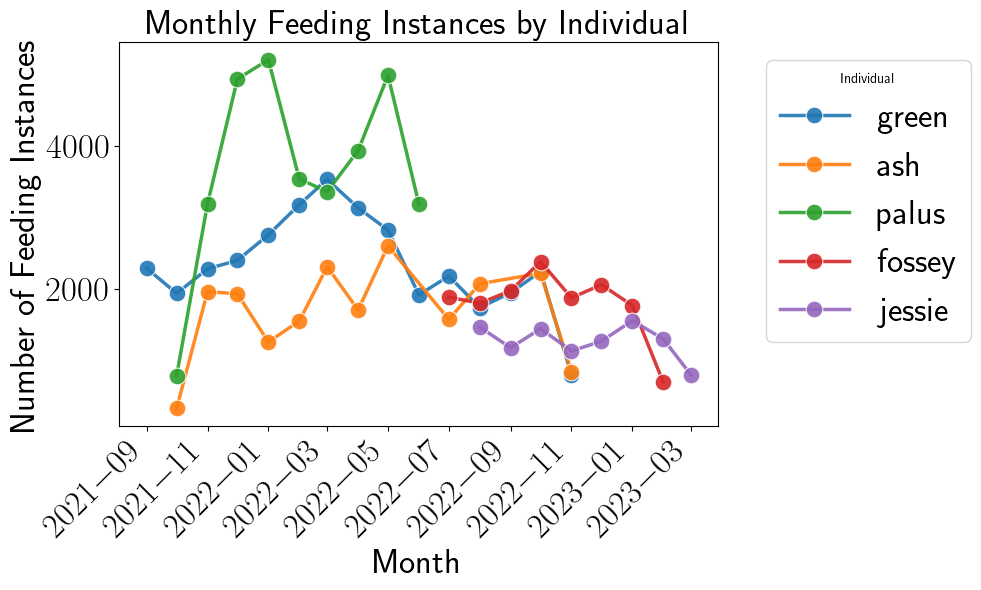

In [76]:
plot_monthly_feeding(valid_monthly_counts)